# 06. Machine Learning for music playlists: Random forest classification
This is the 6th post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
The purpose of the analysis is to detect tracks in my iTunes music library that would suit my fitness practices, which are "cycling", "yoga", and "ballet". To solve that problem I use supervised ML classification techniques. 

Previous posts cover the following steps:
* [00_Summary](http://localhost:8888/notebooks/00_Summary.ipynb) — Summary of this analysis, its goals and methods, installation notes.
* [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) — Data gathering and cleaning.
* [02_Data_visualisation](http://localhost:8888/notebooks/02_Data_Visualisation.ipynb) — Visualisation and overview of data.
* [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) — Data preprocessing to use it as input for Scikit-learn machine learning algorithms.
* [04_Novelty_detection](http://localhost:8888/notebooks/04_Novelty_detection.ipynb) — One-Class SVM algorithm to identify matching tracks in the unlabeled dataset.
* [05_kNN_classifier](http://localhost:8888/notebooks/05_kNN_classifier.ipynb) — K-nearest neighbors classification to assign class labels to 289 tracks in the test set.

I have two tables in HDF5 format: 
* training set contains 88 tracks labeled with one of the three classes: "ballet", "cycling", "yoga". Labels are stored as a pandas Series;
* test set contains 289 tracks labeled as matching the training set and 155 tracks as non-matching. In the [04_Novelty_detection](http://localhost:8888/notebooks/04_Novelty_detection.ipynb) notebook I used One-Class SVM to choose tracks in the test set that match training data. As a result, each track was identified either as matching or not.

In this post I continue testing different supervised ML classifiers. This time I apply **[Random Forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)** to assign every track in the matching group one of the classes. 

As a shortcut, I import modules:
* "data_processing" with functions from the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) and [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) notebooks;
* "estimator_handling" with functions from the [05_kNN_classification](http://localhost:8888/notebooks/05_KNN_classification.ipynb) notebook. In this post I will not go into detail about algorithms I used in the previous post [05_kNN_classification](http://localhost:8888/notebooks/05_KNN_classification.ipynb).

I start with importing the modules required in the following notebook.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# import my modules
import data_processing as prs
import estimator_handling as esh

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

### Read in data

In [2]:
# open an hdf5 file
store = pd.HDFStore('music_data.h5')
store

<class 'pandas.io.pytables.HDFStore'>
File path: music_data.h5
/knn_df               frame_table  (typ->appendable,nrows->289,ncols->14,indexers->[index])
/rfc_df               frame_table  (typ->appendable,nrows->289,ncols->14,indexers->[index])
/target               series       (shape->[88])                                           
/test_svm             frame_table  (typ->appendable,nrows->444,ncols->12,indexers->[index])
/train_std            frame_table  (typ->appendable,nrows->88,ncols->11,indexers->[index]) 

Both sets are stored as pandas DataFrames. I convert these to numpy arrays because Scikit-Learn algorithms expect a numpy array as input. I also save index in the test set as a column when converting it to a numpy array. Thus it will be easier to identify each track after classification, where I'll be using only tracks labeled as matching.
Data in both sets were standardized in the pre-processing step.

In [3]:
# get training data (standardized) and convert to numpy array
train_std = prs.convert_df_to_array(store['train_std'])

# get test data (standardized) and convert to numpy array
test_std = prs.convert_df_to_array(store['test_svm'].reset_index())

# matching tracks
match_test = test_std[(test_std[:, 12] == 1)]

# target data as numpy array
target = store['target'].values

# list class labels
labels = ['ballet', 'cycling', 'yoga']

In [4]:
print "Data overview: "
print "Train data shape:", train_std.shape
print "Test data shape:", test_std.shape
print "Test data only with matching tracks:", match_test.shape

Data overview: 
Train data shape: (88, 11)
Test data shape: (444, 13)
Test data only with matching tracks: (289, 13)


## Random Forest Classifier
Random forests are an example of an ensemble learner built on decision trees. The estimator builds multiple decision trees on various sub-samples of the dataset and let them vote on how to classify inputs. The estimator uses averaging to improve the predictive accuracy and control over-fitting. In training a decision tree classifier, the algorithm looks at the features and decides which "splits" contain the most information.

In [5]:
from sklearn.ensemble import RandomForestClassifier

The process I use for classification task is as follows:
1. Tune parameters using GridSearchCV.
2. Create and train the model.
3. Estimate model accuracy score.
4. Make predictions and estimate probability.
5. Record the result to the set and DF.
6. Review the results.
7. Visualize the model.
8. Apply probability threshold. 
9. Summary

### 1. Tune parameters using GridSearchCV
I start with GridSearchCV parameter tuning to choose: 
* the number of trees in the forest (n_estimators: 10, 50 or 100), 
* the optimal number of features considered at each step a branch is made (max_features: 50%, 70% or 100% of features); 
* the maximum number of branches (max_depth: 5 levels, 8 levels or no limitations).

In [6]:
from sklearn.grid_search import GridSearchCV

# tune parameters
parameter_grid = {'n_estimators': [10, 50, 100],
                  'max_features': [0.5, 0.7, 1.],
                  'max_depth': [5., 8., None]}

grid_search = GridSearchCV(RandomForestClassifier(), 
                           parameter_grid, cv=6)

grid_search.fit(train_std, target)

# review the result
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

[mean: 0.75000, std: 0.06023, params: {'max_features': 0.7, 'n_estimators': 10, 'max_depth': 5.0},
 mean: 0.75000, std: 0.07207, params: {'max_features': 1.0, 'n_estimators': 10, 'max_depth': 8.0},
 mean: 0.76136, std: 0.12289, params: {'max_features': 0.5, 'n_estimators': 10, 'max_depth': 8.0},
 mean: 0.77273, std: 0.06794, params: {'max_features': 1.0, 'n_estimators': 10, 'max_depth': 5.0},
 mean: 0.77273, std: 0.05011, params: {'max_features': 1.0, 'n_estimators': 50, 'max_depth': 5.0},
 mean: 0.77273, std: 0.10390, params: {'max_features': 0.7, 'n_estimators': 10, 'max_depth': 8.0},
 mean: 0.78409, std: 0.05968, params: {'max_features': 0.7, 'n_estimators': 100, 'max_depth': 8.0},
 mean: 0.78409, std: 0.09764, params: {'max_features': 1.0, 'n_estimators': 10, 'max_depth': None},
 mean: 0.79545, std: 0.08469, params: {'max_features': 0.5, 'n_estimators': 10, 'max_depth': 5.0},
 mean: 0.79545, std: 0.07967, params: {'max_features': 0.7, 'n_estimators': 50, 'max_depth': 5.0},
 mean: 0

In [7]:
# define the winner
rfc_best_score = grid_search.best_score_
best_params = grid_search.best_params_
n_estimators = best_params['n_estimators']
max_features = best_params['max_features']
max_depth = best_params['max_depth']

print ("The best-performing tuning parameters"
       "\nBest score: {0:.4f};"
       "\nNumber of trees: {1};"
       "\nMax features: {2:.0%};"
       "\nMax branches: {3}."
       .format(rfc_best_score,
               n_estimators,
               max_features,
              max_depth))

The best-performing tuning parameters
Best score: 0.8523;
Number of trees: 100;
Max features: 100%;
Max branches: 8.0.


### 2. Create and train the model
Next I create a model using the parameters defined by GridSearchCV.

In [8]:
# create the model
rfc = RandomForestClassifier(n_estimators=n_estimators, 
                             random_state=0,
                             max_features=max_features, 
                             max_depth=max_depth)

# train the model
rfc.fit(train_std, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.0, max_features=1.0, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### 3. Estimate model accuracy score
I use 10-fold cross validation.

In [9]:
from sklearn.cross_validation import cross_val_score

# calculate model accuracy score
cvs = cross_val_score(rfc, train_std, target, 
                    scoring='accuracy', cv=10).mean()

In [10]:
# Build a text report showing the main classification metrics
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
    
predicted = cross_val_predict(rfc, train_std, 
                            target, cv=10)

print ("Random Forest classification model "
       "accuracy score: {:.3f}"
       .format(cvs))
print "Model report \n", 
print classification_report(target, predicted, 
                            target_names=labels)

Random Forest classification model accuracy score: 0.828
Model report 
             precision    recall  f1-score   support

     ballet       0.74      0.85      0.79        34
    cycling       0.94      0.97      0.95        31
       yoga       0.82      0.61      0.70        23

avg / total       0.83      0.83      0.83        88



The overall accuracy of the model is high. All three classes have high scores. 

The "cycling" class has the highest precision and recall ratio. That means that the pureness of model prediction for that class is 0.97 (3% of tracks assigned this class have a different label). At the same time 97% of tracks belonging to that class were identified correctly by the model.

The "ballet" class is easier to identify (88% of tracks belonging to that class were identified correctly by the model) however the precision ratio is a bit lower (0.76). It looks like some tracks from the "yoga" class were assigned the "ballet" label.

The "yoga" class has the lowest recall ratio. The precision ratio, however, is high. That means that just 17% of tracks assigned the "yoga" label have a different label but at the same time 35% of tracks with the "yoga" label were assigned a different class.

### 4. Make predictions and estimate probability
Satisfied with the model performance on the training set, I apply it to the test set to make predictions using predict method. 

In [11]:
# make predictions
# exclude index and novelty result
rfc_output = rfc.predict(match_test[:, 1:12])

Random Forest classifier has predict_proba method that can predict the probability of class membership. For every query point it will calculate the probablity of belonging to each class. I use that [function](http://localhost:8888/notebooks/05_KNN_classification.ipynb#4.-Make-predictions-and-estimate-probability) from the previous post.

In [12]:
# classification probability
rfc_prob = esh.class_prob(rfc, match_test[:, 1:12])

### 5. Record the result
I add the model prediction and probability to the matching set and then to the DF. I store the resulting dataframe as a hdf5 file. 

In [13]:
# add the result to the matching set
rfc_set = np.concatenate((match_test, rfc_output[:, None], rfc_prob), 1)

# review the result
print rfc_set.shape
print "\nSample of the resulting set: "
rfc_set[:3]

(289, 15)

Sample of the resulting set: 


array([[ 0.        , -1.20843788,  0.63488137,  1.25808605, -0.88779748,
        -0.49132844,  0.78719594, -1.1740436 , -0.39262975, -0.74488995,
         0.43101536,  0.57687657,  1.        ,  1.        ,  0.9       ],
       [ 1.        , -0.2793643 , -0.95059729, -0.59717964,  1.12009741,
         1.26151896,  0.17775694, -1.1740436 , -0.80693268,  0.63767235,
        -0.87689333, -0.01472446,  1.        ,  0.        ,  0.74      ],
       [ 2.        ,  0.72038789,  1.90749621, -0.54831972,  1.14486486,
         0.38509526, -0.33955242,  0.85175712, -0.08956489,  0.29581684,
         0.43101536,  1.24591181,  1.        ,  0.        ,  0.63      ]])

In [14]:
# transform the set back into pandas dataframe
rfc_df = esh.nparray_to_df(rfc_set, store)

# review the result
rfc_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,label,prob
index,,,,,,,,,,,,,,
82,-0.58,0.74,0.46,-0.91,1.26,0.17,0.85,-0.41,-0.86,0.43,1.34,1,1,0.82
17,-0.26,1.27,0.62,-0.83,-1.37,0.78,0.85,-0.97,0.44,0.43,0.67,1,1,0.97
147,-0.94,0.50,1.17,0.69,-1.37,0.09,0.85,3.40,-0.08,0.43,-0.26,1,0,0.81


In [15]:
# save in HDF5
rfc_df.to_hdf('music_data.h5', 'rfc_df', format='table')

### 6. Review the result
I use [that function](http://localhost:8888/notebooks/05_KNN_classification.ipynb#6.-Review-the-result) from the previous post.

In [16]:
# print the summary
esh.model_summary(rfc_df, rfc, 'Random Forest', labels, cvs)

Summary of the Random Forest classifier performance

Model: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.0, max_features=1.0, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Model accuracy score: 0.828

Number of tracks in the test set: 289.
Number of tracks assigned to the "ballet" class: 121, or 41.87% of all tracks.
Number of tracks assigned to the "cycling" class: 156, or 53.98% of all tracks.
Number of tracks assigned to the "yoga" class: 12, or 4.15% of all tracks.

Mean probability for each category
label
0   0.72
1   0.87
2   0.76
Name: prob, dtype: float64


The "cycling" class has the highest mean probability, which means that on average tracks are assigned this class with 82% certainty. At the same time this is the most popular class — almost 60% of all tracks in the test set are assigned the "cycling" class.
The "ballet" class is doing alright. Almost 40% of all tracks are assigned this class label with 70% certainty on average.
The "yoga" class has the fewest representatives in the test set. Only 12 tracks were assigned this class label. The mean probability is the lowest among the three classes (68%).

### 7. Visualize the model
To visualize the model I apply the function that was used by Jake VanderPlas for his [Scikit-learn tutorial](https://github.com/jakevdp/sklearn_pycon2015) at PyCon 2015.

In [78]:
def visualize_tree(estimator, X, y, test, labels,
                   boundaries=False):
    
    # clone the estimator to apply it to a 2d data
    from sklearn.base import clone
    model = clone(estimator)
    model.fit(X, y)

    xlim = (test[:, 0].min() - 0.1, test[:, 0].max() + 0.1)
    ylim = (test[:, 1].min() - 0.1, test[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.4, cmap='YlGnBu')
    plt.clim(y.min(), y.max())

    # plot the training points
    for l,c in zip(range(0,3), 
                   ('olive', 'teal', 'purple')):
        plt.scatter(X[y==l, 0], 
                    X[y==l, 1],
                    c=c, s=50, 
                    label=labels[l])
    
    # plot test points
    plt.scatter(test[:,0], test[:, 1], 
                c='tan', s=20, alpha=0.7,
               label='test observations')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    plt.title("Random Forest classifier decision boundaries")
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.,
               loc=2)
    sns.despine()
    
    # plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = model.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

Since it's hard to plot 11 dimensions in a 2 dimensional space, I need to perform dimensionality reduction with a PCA algorithm. I use that [function](http://localhost:8888/notebooks/03_Preprocessing.ipynb#Dimensionality-reduction) from the previous notebook [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb).

In [18]:
# reduce dimensions
train_2d, match_2d = prs.reduce_dimensions(train_std, match_test[:, 1:12])

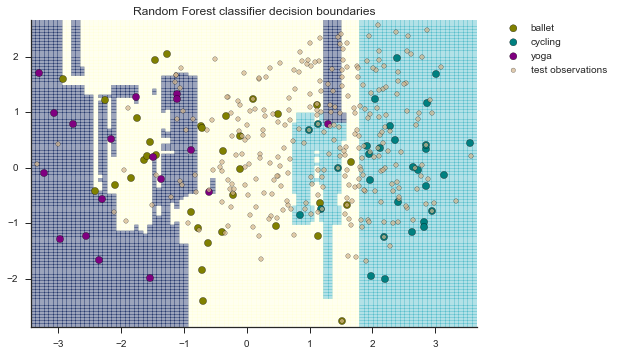

In [79]:
# plot random forest classifier
visualize_tree(rfc, train_2d, target, match_2d, labels)

### 7. Apply probability threshold
In my playlists I want to keep only tracks with high probability of class membership. To decide on the threshold for  probability estimate I plot number of tracks in each class with a threshold varying from 0 to 100%. 
#### Make a plot

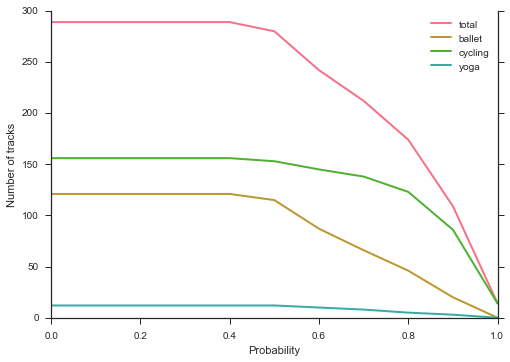

In [20]:
# threshold values
xs = list(a / 10.0 for a in range(11))

# all classes
total = [len(esh.prob_with_threshold(rfc_df, i)) for i in xs]
line_total = plt.plot(xs, total, linewidth=2, label='total')

for lb in labels:
    lb_sum = [esh.sum_category(esh.prob_with_threshold(rfc_df, i), 
                             labels.index(lb)) for i in xs]
    line_lb = plt.plot(xs, lb_sum, linewidth=2, label=lb)

plt.ylabel('Number of tracks')
plt.xlabel('Probability')
plt.legend()
sns.despine(top=True, right=False)
plt.show()

As in the [previous post](http://localhost:8888/notebooks/05_KNN_classification.ipynb#Make-a-plot), I apply the 0.7 probability threshold to data and review the result. It filters out some tracks in each class, eliminating tracks with lower certainty of class membership and, thus, making the playlists more accurate.

In [80]:
# print summary 
esh.summary_of_prob_with_thres(rfc_df, 0.7, labels)

Total number of tracks to classify: 289.
Number of tracks with 0.7 probability of class membership: 212.
Among which...
...assigned the "ballet" class: 66 (121 without the threshold).
...assigned the "cycling" class: 138 (156 without the threshold).
...assigned the "yoga" class: 8 (12 without the threshold).

Mean probability for each class
label
0   0.84
1   0.91
2   0.86
Name: prob, dtype: float64


### Summary
In this notebook I applied **Random Forest classification** tecnique to identify class membership of every track in the matching group and assign a class label. I started by tuning model parameters using scikit-learn tool GridSearchCV. I estimated model accuracy using K-fold cross validation tecnique.  

The estimated **model accuracy score** equals **0.786**.  

Model prediction results: 
* "ballet" class: 112, or 38.75% of all tracks.
* "cycling" class: 172, or 59.52% of all tracks.
* "yoga" class: 5, or 1.73% of all tracks.

The "cycling" class has the highest mean probability, which means that on average tracks are assigned this class with 83% certainty. At the same time this is the most popular class — almost 60% of all tracks in the test set are assigned the "cycling" class. 

The "ballet" class is doing alright. Almost 40% of all tracks are assigned this class label with 72% certainty on average. 

The "yoga" class has the fewest representatives in the test set. Only 5 tracks were assigned this class label. The mean probability is the lowest among the three classes (63%).

I applied 0.7 probability threshold to model predictions of class membership. As a result the "ballet" class lost 35% of tracks (73 are left), the "cycling" class lost about 24% (131 tracks left), and the "yoga" class is left with only 2 tracks (60% lost).

Data and results of this classification are stored in a HDF5 file. 

In the next post I'm going to try Support Vector Classifier. In the end I will compare the results of all applied classifiers.